**Data Source: Official Trump USD (Historical Data), Coingecko.** <br>
**Retrived from** https://www.coingecko.com/en/coins/official-trump/historical_data

# Libraries and Data

In [290]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
%cd /content/drive/MyDrive/N-BEATS

/content/drive/MyDrive/N-BEATS


In [292]:
# Install the darts library
!pip install -q darts

In [293]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel

#warning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
# Silence PyTorch Lightning logs
pl_logger = logging.getLogger("pytorch_lightning")
pl_logger.setLevel(logging.WARNING)

In [294]:
df_raw = pd.read_csv('trump-usd-max.csv')
df_raw = df_raw.rename(columns={'snapped_at': 'ds', 'price': 'y'})
df_raw['ds'] = pd.to_datetime(df_raw['ds'])
df_raw = df_raw.set_index('ds')
df = df_raw.asfreq('D')
df.head()

,y,market_cap,total_volume
ds,,,
2025-01-18 00:00:00+00:00,28.929288,5.821894e+09,1.319784e+10
2025-01-19 00:00:00+00:00,28.929288,5.821894e+09,1.319784e+10
2025-01-20 00:00:00+00:00,42.275146,8.424686e+09,3.606988e+10
2025-01-21 00:00:00+00:00,36.802050,7.502005e+09,2.308167e+10
2025-01-22 00:00:00+00:00,44.283511,8.792419e+09,1.881790e+10


We only use beef meat type

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2025-01-18 00:00:00+00:00 to 2025-06-11 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             145 non-null    float64
 1   market_cap    145 non-null    float64
 2   total_volume  145 non-null    float64
dtypes: float64(3)
memory usage: 4.5 KB


In [296]:
df.isnull().sum()

,0
y,0
market_cap,0
total_volume,0


# Exploratory Data Analysis

<Axes: title={'center': 'Mongolia Beef Price'}, xlabel='ds'>

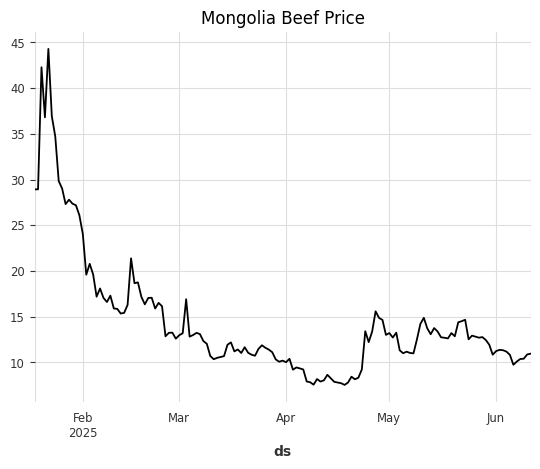

In [297]:
df['y'].plot(title = 'Mongolia Beef Price')

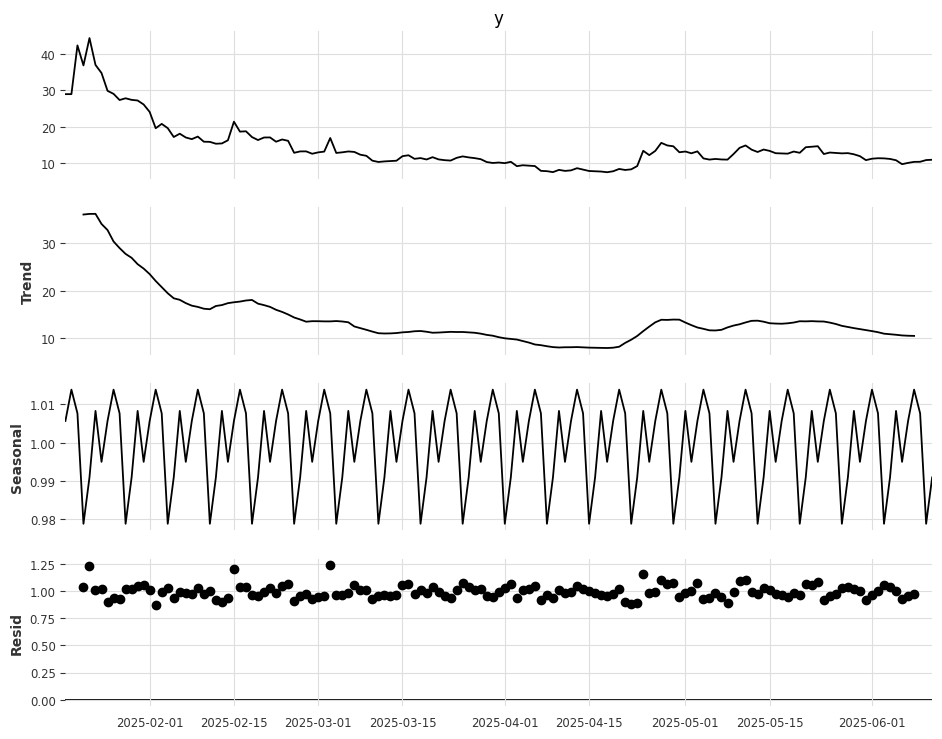

In [298]:
# Perform seasonal decomposition of the electricity price data using an additive model
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 7)

# Plot the decomposed components (trend, seasonal, and residual)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

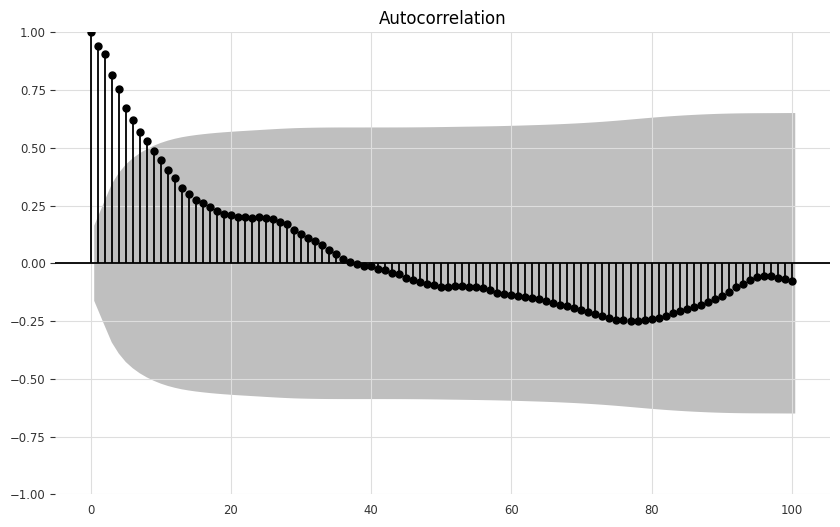

In [299]:
# Plot the autocorrelation function (ACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax) # Generate the ACF plot with 100 lags
plt.show()

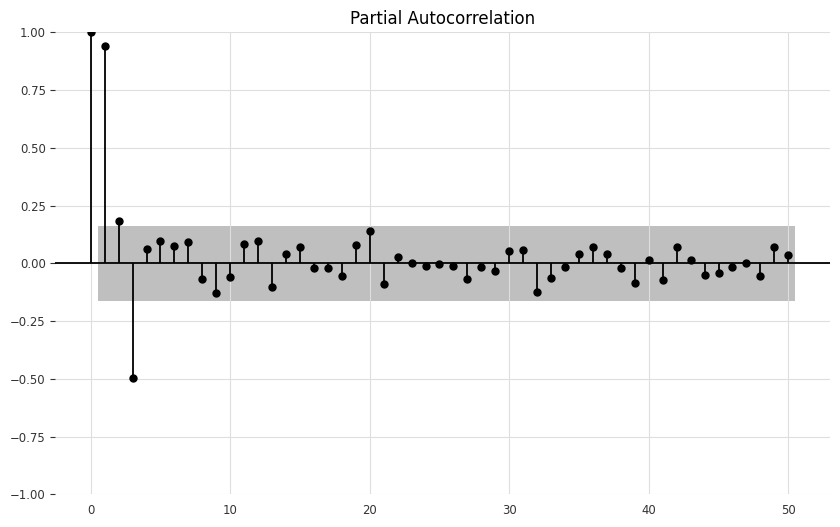

In [300]:
# Plot the partial autocorrelation function (PACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 50, ax = ax)
plt.show()

# Train-Test Split

In [301]:
# split train test data
train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]
df_test

,y,market_cap,total_volume
ds,,,
2025-05-14 00:00:00+00:00,13.759393,2.751878e+09,1.585485e+09
2025-05-15 00:00:00+00:00,13.384315,2.676863e+09,1.154057e+09
2025-05-16 00:00:00+00:00,12.749399,2.549880e+09,1.074541e+09
2025-05-17 00:00:00+00:00,12.698336,2.541482e+09,6.982879e+08
2025-05-18 00:00:00+00:00,12.626500,2.525299e+09,9.377712e+08
2025-05-19 00:00:00+00:00,13.209583,2.627726e+09,1.033219e+09
2025-05-20 00:00:00+00:00,12.857324,2.568400e+09,7.686989e+08
2025-05-21 00:00:00+00:00,14.388620,2.871077e+09,1.138274e+09
2025-05-22 00:00:00+00:00,14.511806,2.904307e+09,2.335428e+09


# Series And Seasonality

In [302]:
# Prepare a TimeSeries object from the dataframe with Hourly frequency
series = TimeSeries.from_dataframe(df_train,
                                   value_cols = 'y',
                                   freq = 'D')
series

<TimeSeries (DataArray) (ds: 116, component: 1, sample: 1)> Size: 928B
array([[[28.92928831]],

       [[28.92928831]],

       [[42.27514577]],

       [[36.8020503 ]],

       [[44.28351132]],

       [[36.92866145]],

       [[34.71527596]],

       [[29.84004748]],

       [[29.00657212]],

       [[27.31725535]],

...

       [[11.32510013]],

       [[11.00374416]],

       [[11.17887056]],

       [[11.03631924]],

       [[10.99476094]],

       [[12.5169817 ]],

       [[14.21437053]],

       [[14.88034018]],

       [[13.72718291]],

       [[13.08308457]]])
Coordinates:
  * ds         (ds) datetime64[ns] 928B 2025-01-18 2025-01-19 ... 2025-05-13
  * component  (component) <U1 4B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [303]:
# Function to encode the year as a normalized value
def encode_year(idx):
  return (idx.year - 2000) / 50

In [304]:
# Set up the add_encoders dictionary to specify how different time-related encoders and transformers should be applied
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'utc'
}

# Past Covariates

In [305]:
# Isolating the Past Covariates
X_past = df_train.iloc[:,1:]
# Convert the isolated past covariates into a TimeSeries object with Hourly frequency
past_covariates = TimeSeries.from_dataframe(X_past,
                                            freq = 'D')
past_covariates

<TimeSeries (DataArray) (ds: 116, component: 2, sample: 1)> Size: 2kB
array([[[5.82189423e+09],
        [1.31978405e+10]],

       [[5.82189423e+09],
        [1.31978405e+10]],

       [[8.42468647e+09],
        [3.60698787e+10]],

       [[7.50200451e+09],
        [2.30816684e+10]],

       [[8.79241884e+09],
        [1.88178989e+10]],

       [[7.38864102e+09],
        [5.84780591e+09]],

       [[6.94995913e+09],
        [5.74370472e+09]],
...
       [[2.20720675e+09],
        [6.20874448e+08]],

       [[2.19898681e+09],
        [4.80235865e+08]],

       [[2.50184856e+09],
        [1.69942576e+09]],

       [[2.83962636e+09],
        [3.10471230e+09]],

       [[2.96145103e+09],
        [1.73640067e+09]],

       [[2.74630782e+09],
        [1.42470531e+09]],

       [[2.61716615e+09],
        [2.61711295e+09]]])
Coordinates:
  * ds         (ds) datetime64[ns] 928B 2025-01-18 2025-01-19 ... 2025-05-13
  * component  (component) <U12 96B 'market_cap' 'total_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Scaling

In [306]:
# Import the Scaler class and initialize two instances of it
scaler1 = Scaler()
scaler2 = Scaler()

In [307]:
# Apply the scaler1 to the time series
y_transformed = scaler1.fit_transform(series)

In [308]:
# Apply the scaler2 to the past covariates
past_covariates_transformed = scaler2.fit_transform(past_covariates)

# N-BEATS model

In [309]:
forecast_horizon = 7

In [310]:
# Define the N-BEATS model with specified parameters
model = NBEATSModel(
       input_chunk_length = 30,          # Reduce context
    output_chunk_length = forecast_horizon,          # Predict 1 week ahead
    n_epochs = 300,                   # Train longer
    batch_size = 16,                  # Smaller batches okay
    num_stacks = 4,
    num_blocks = 1,
    num_layers = 2,
    layer_widths = 64,
    random_state = 42,
    add_encoders = add_encoders
    #pl_trainer_kwargs = {'accelerator': 'gpu',   # Training on GPU
                        # 'devices': [0]}
)

# Fit the model to the transformed time series data with past covariates
model.fit(y_transformed,
          past_covariates = past_covariates_transformed)

Training: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=4, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=300, batch_size=16, random_state=42, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'})

# Cross-validation

In [311]:
# Ensure only 1-2 folds max, based on data size
cv = model.historical_forecasts(
    series = y_transformed,
    past_covariates = past_covariates_transformed,
    start = 50,
    forecast_horizon = 24,
    stride = 24,
    retrain = True,
    last_points_only = False
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [312]:
rmse_cv = []

# Remove timezone if needed (once before loop)
if hasattr(df_train.index, 'tz') and df_train.index.tz is not None:
    df_train.index = df_train.index.tz_localize(None)

for i, forecast_ts in enumerate(cv):
    # Inverse-transform prediction
    ts = scaler1.inverse_transform(forecast_ts)
    predictions = pd.Series(ts.values().flatten(), index=ts.time_index)

    # Align actual values
    actuals = df_train['y'].reindex(predictions.index).dropna()
    predictions = predictions.loc[actuals.index]

    if len(actuals) == 0 or len(predictions) == 0:
        print(f"Skipping fold {i+1}: no matching actual values.")
        continue

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(rmse)
    print(f"Fold {i+1}: RMSE = {rmse:.4f}")

if rmse_cv:
    print(f"\n✅ Average RMSE across {len(rmse_cv)} fold(s): {np.mean(rmse_cv):.4f}")
else:
    print("❌ No usable folds for evaluation.")


Fold 1: RMSE = 2.1615
Fold 2: RMSE = 2.9833

✅ Average RMSE across 2 fold(s): 2.5724


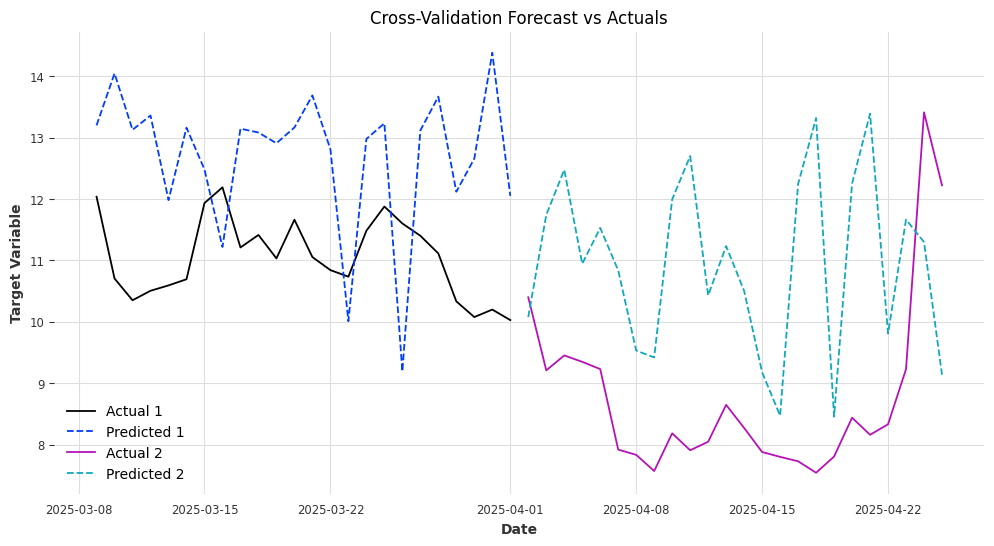

In [313]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(cv)):
    # Inverse transform and convert to pandas Series
    ts = scaler1.inverse_transform(cv[i])
    predictions = pd.Series(ts.values().flatten(), index=ts.time_index)

    # Align actual values
    actuals = df_train['y'].reindex(predictions.index).dropna()
    predictions = predictions.loc[actuals.index]

    # Plot
    ax.plot(actuals, label=f"Actual {i+1}")
    ax.plot(predictions, label=f"Predicted {i+1}", linestyle='dashed')

# Final plot decorations
ax.legend()
ax.set_title("Cross-Validation Forecast vs Actuals")
ax.set_xlabel("Date")
ax.set_ylabel("Target Variable")

plt.show()


# Parameter Tuning

In [314]:
from sklearn.model_selection import ParameterSampler
param_grid = {
    'input_chunk_length': [24, 30, 36],      # small enough for short data
    'output_chunk_length': [7],              # fixed to 1-week forecast
    'n_epochs': [100],                       # keep high for small models
    'batch_size': [8, 16],                   # small batches due to limited data
    'num_stacks': [2, 4],                    # small and fast
    'num_blocks': [1],                       # keep shallow
    'num_layers': [1, 2],                    # low depth
    'layer_widths': [32, 64]                 # lightweight hidden layers
}


In [315]:
# Define parameters that remain constant during the tuning
fixed_params = {
    'output_chunk_length': forecast_horizon,      # Length of the forecast horizon
    'add_encoders': add_encoders,                 # Encoders to add to the model
    'random_state': 1502                        # Random seed for reproducibility
    #'pl_trainer_kwargs': {'accelerator': 'gpu',   # GPU settings for training
                          #'devices': [0]}
}


In [316]:
# Number of random parameter combinations to generate
n_iter = 15

# Generate a list of random parameter combinations for tuning
param_list = list(ParameterSampler(param_grid,
                                   n_iter=n_iter,
                                   random_state=1502))

In [317]:
# Duplicate the parameter list for further use or comparison
param_list2 = param_list

In [318]:
# Update each parameter set in the list with the fixed parameters
for params in param_list:
  params.update(fixed_params)

In [319]:


# Initialize a list to store RMSE values for each set of parameters
rmse = []

# Iterate over each set of parameter combinations
for params in param_list:
    # Build the TFT model using the current set of parameters
    model = NBEATSModel(**params)

    # Perform cross-validation with rolling forecast
    cv = model.historical_forecasts(
        series=y_transformed,
        past_covariates=past_covariates_transformed,
        forecast_horizon=forecast_horizon,
        start=50,
        retrain=True,
        stride=forecast_horizon,
        last_points_only=False
    )

    # Initialize a list to store RMSE values for each fold
    rmse_cv = []

    # Evaluate each fold
    for i in range(len(cv)):
        # Inverse transform predictions to original scale
        inv_pred = scaler1.inverse_transform(cv[i])

        # Convert to pandas Series
        predictions = inv_pred.to_series()

        # Extract the corresponding actual values
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df_train['y'][start:end]  # Ensure 'y' is the correct column name

        # Compute RMSE for current fold
        error_cv = np.sqrt(mean_squared_error(actuals, predictions))
        rmse_cv.append(error_cv)

    # Compute the average RMSE for the current parameter set
    avg_rmse = np.mean(rmse_cv)
    rmse.append(avg_rmse)

    # Log tested parameters and corresponding RMSE
    print(f"Tested parameters: {params} => RMSE: {avg_rmse:.4f}")



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 36, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.2957


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 24, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.3769


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 30, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.3547


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 30, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.1993


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 30, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.2232


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 36, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.3457


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 30, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.1607


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 30, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.4889


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 2, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 36, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.2384


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 24, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.4153


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 24, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.3870


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 1, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 36, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.5152


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 36, 'batch_size': 8, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.2533


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 32, 'input_chunk_length': 36, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.0885


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Tested parameters: {'output_chunk_length': 7, 'num_stacks': 4, 'num_layers': 2, 'num_blocks': 1, 'n_epochs': 100, 'layer_widths': 64, 'input_chunk_length': 36, 'batch_size': 16, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddc4407740>], 'future': [<function encode_year at 0x78ddc4407740>]}, 'transformer': Scaler, 'tz': 'utc'}, 'random_state': 1502} => RMSE: 2.4528


In [320]:
results_df = pd.DataFrame(param_list2)
results_df['rmse'] = rmse
results_df

,output_chunk_length,num_stacks,num_layers,num_blocks,n_epochs,layer_widths,input_chunk_length,batch_size,add_encoders,random_state,rmse
0,7,2,2,1,100,64,36,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.295683
1,7,4,1,1,100,64,24,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.376854
2,7,2,1,1,100,32,30,16,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.354657
3,7,4,2,1,100,64,30,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.199293
4,7,2,1,1,100,32,30,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.223160
5,7,2,2,1,100,64,36,16,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.345700
6,7,2,1,1,100,64,30,16,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.160652
7,7,4,1,1,100,32,30,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.488891
8,7,2,1,1,100,32,36,8,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.238381
9,7,4,2,1,100,32,24,16,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...",1502,2.415283


In [321]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = results_df.sort_values(by = 'rmse').iloc[0]
best_params.to_csv("best_params.csv")

# Predict the future

In [358]:
df = pd.read_csv('trump-usd-max.csv')
df = df.rename(columns={'snapped_at': 'ds', 'price': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').asfreq('D')

In [359]:
series = TimeSeries.from_dataframe(df, value_cols='y', freq='D')
past_cov = TimeSeries.from_dataframe(df[['market_cap', 'total_volume']], freq='D')

In [361]:
scaler1 = Scaler()
scaler2 = Scaler()
y_transformed = scaler1.fit_transform(series)
past_cov_transformed = scaler2.fit_transform(past_cov)

In [362]:
# --- Train-test split ---
train_series, test_series = y_transformed.split_before(0.8)
train_cov, test_cov = past_cov_transformed.split_before(0.8)
forecast_horizon = len(test_series)

In [346]:
# --- Load best params from CSV ---
best_params = pd.read_csv("best_params.csv", index_col=0).drop(['rmse'])
best_params_dict = best_params.squeeze().to_dict()

In [363]:
def encode_year(idx):
    return (idx.year - 2000) / 50

add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'utc'
}

best_params_dict['add_encoders'] = add_encoders


In [350]:
# --- Safely convert numeric params ---
for key, value in best_params_dict.items():
    try:
        best_params_dict[key] = int(value)
    except (ValueError, TypeError):
        continue

In [351]:
# --- Add fixed params (like output_chunk_length) ---
fixed_params = {
    'output_chunk_length': forecast_horizon,
    'random_state': 42
}
best_params_dict.update(fixed_params)

In [352]:
# --- Build and fit model ---
tuned_model = NBEATSModel(**best_params_dict)
tuned_model.fit(train_series, past_covariates=train_cov)


Training: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=4, num_blocks=1, num_layers=2, layer_widths=32, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, output_chunk_length=30, n_epochs=100, input_chunk_length=36, batch_size=16, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x78ddbfaf63e0>], 'future': [<function encode_year at 0x78ddbfaf63e0>]}, 'transformer': Scaler, 'tz': 'utc'}, random_state=42)

In [368]:
forecast_ts = tuned_model.predict(
    n=forecast_horizon,
    past_covariates=past_cov_transformed  # seluruh covariates, bukan hanya test_cov
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [369]:
# --- Inverse transform forecast ---
forecast_ts_inv = scaler1.inverse_transform([forecast_ts])[0]

# --- Convert to pandas Series for plotting (optional)
forecast_series = pd.Series(
    forecast_ts_inv.values().flatten(),
    index=forecast_ts_inv.time_index,
    name="N-BEATS"
)


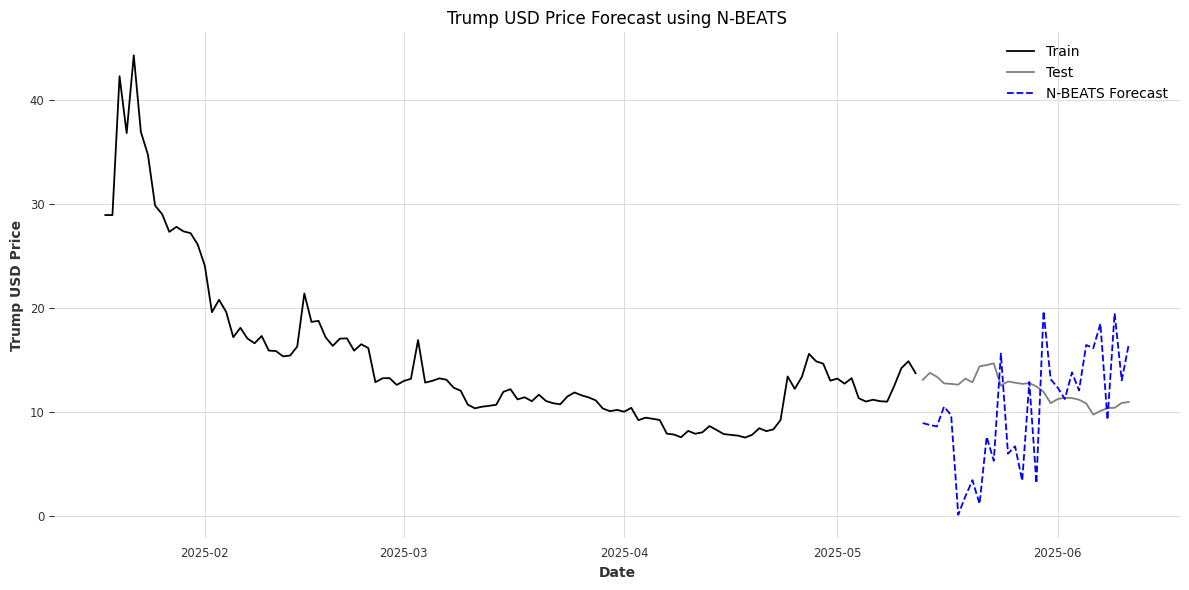

In [370]:

# --- Inverse transform test_series for comparison ---
test_series_inv = scaler1.inverse_transform([test_series])[0]
train_series_inv = scaler1.inverse_transform([train_series])[0]

# --- Plot train, test, forecast ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actuals
ax.plot(train_series_inv.time_index, train_series_inv.values().flatten(), label="Train", color='black')
ax.plot(test_series_inv.time_index, test_series_inv.values().flatten(), label="Test", color='gray')

# Plot forecast
ax.plot(forecast_ts_inv.time_index, forecast_ts_inv.values().flatten(), label="N-BEATS Forecast", linestyle='dashed', color='blue')

# Aesthetic
ax.set_title("Trump USD Price Forecast using N-BEATS")
ax.set_xlabel("Date")
ax.set_ylabel("Trump USD Price")
ax.legend()
plt.tight_layout()
plt.show()